In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
import os
from sklearn.preprocessing import LabelEncoder
import datetime
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data.read_parallel import read_parallel_local
from src.models.deeplegis import *
from src.models.data_loader import *
from src.models.configurationClasses import deepLegisConfig

from transformers import BertTokenizerFast
import pickle
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# config = deepLegisConfig("bert_128.json", project_root="../")
# df, encoder = createDeepLegisDataFrame(config, read_cached=False)
# df.to_pickle("/home/luke/ml_govhawk_prod_output/preprocessed_df_128.pkl")

In [3]:
# config = deepLegisConfig("bert_512.json", project_root="../")
# df, encoder = createDeepLegisDataFrame(config, read_cached=False)
# df.to_pickle("/home/luke/ml_govhawk_prod_output/preprocessed_df_512.pkl")

In [4]:
from transformers import LongformerTokenizer
config = deepLegisConfig("bert_128.json", project_root="../")
df, encoder = createDeepLegisDataFrame(config, read_cached=True)

Loading pickle file (/home/luke/ml_govhawk_prod_output/preprocessed_df_128.pkl) took 0.25059169533333353 min -  15.0355 seconds
Original number of examples: 199646


In [5]:
df = df.drop(['tokens'], axis=1)

In [3]:
## No max length. For use with longformer.


tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
def tokenizer_wrapper(text):
    d = tokenizer(text, truncation=True, padding='max_length', max_length=4096)
    return (d['input_ids'], d['attention_mask'])
tic = time.perf_counter()
ids_attention = df.text.parallel_apply( tokenizer_wrapper)
toc = time.perf_counter()
print(f"Tokenized in {(toc-tic)/60.0} min -  {toc - tic:0.4f} seconds")
df.head()


Loading pickle file (/home/luke/ml_govhawk_prod_output/preprocessed_df_128.pkl) took 0.0359243398833011 min -  2.1555 seconds
Original number of examples: 199646
Tokenized in 100.10227949545006 min -  6006.1368 seconds


,id,version_number,bill_id,signed,passed,partisan_lean,sc_id,sc_id_cat,text,tokens
0,2708956,10,1092981,0,0,0.236118,562-1,6,amendment no. to hb0001 miller signature of s...,"[101, 7450, 2053, 1012, 2000, 1044, 2497, 8889..."
1,2127866,1,1098149,1,1,0.236118,562-1,6,<billno> <sponsor> senate joint resolution by...,"[101, 1026, 3021, 3630, 1028, 1026, 10460, 102..."
2,2127963,1,1098199,0,0,0.236118,562-1,6,<billno> <sponsor> senate bill by massey an a...,"[101, 1026, 3021, 3630, 1028, 1026, 10460, 102..."
3,2128334,1,1098465,0,0,0.236118,562-1,6,<billno> <sponsor> senate bill by gresham an ...,"[101, 1026, 3021, 3630, 1028, 1026, 10460, 102..."
4,2128986,1,1098872,1,1,0.236118,562-1,6,<billno> <sponsor> senate joint resolution by...,"[101, 1026, 3021, 3630, 1028, 1026, 10460, 102..."


In [6]:
pickle.dump(ids_attention, open( "ids_attention", "wb" ) )

0    ([0, 8322, 117, 4, 7, 1368, 428, 27623, 7259, ...
1    ([0, 28696, 24916, 2362, 15698, 28696, 32974, ...
2    ([0, 28696, 24916, 2362, 15698, 28696, 32974, ...
3    ([0, 28696, 24916, 2362, 15698, 28696, 32974, ...
4    ([0, 28696, 24916, 2362, 15698, 28696, 32974, ...
Name: text, dtype: object

In [6]:
ids_attention = pickle.load( open( "ids_attention", "rb" ) )

In [7]:
#ids_atten_df = pd.DataFrame(ids_attention)

In [8]:
ids_atten_df = ids_attention.apply(pd.Series)

In [9]:
ids_atten_df.columns = ("tokens", "attention_mask")
ids_atten_df.head()
df['tokens'] = ids_atten_df.tokens
#df['attention_mask'] = ids_atten_df.attention_mask

In [10]:
len(df.tokens[100])

4096

In [ ]:
df.to_pickle("/home/luke/ml_govhawk_prod_output/preprocessed_df_longformer_4096.pkl")

In [21]:
lengths = df.tokens.parallel_apply(len)

Text(0.5, 1.0, 'Token length of bills - LongformerTokenizer')

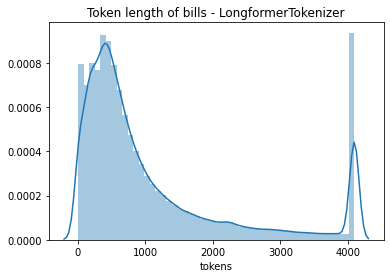

In [27]:
import seaborn
seaborn.distplot(lengths).set_title("Token length of bills - LongformerTokenizer")

In [26]:
np.mean(lengths==4096)

0.07474229386013244

In [ ]:
np.mean(df.tokens)

In [ ]:
np.median(df.tokens)